## imports

In [1]:
# https://github.com/tbenst/glia
# please install using `python setup.py develop`
import glia, os, numpy as np, pandas as pd, av, matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm

## Drivers

In [2]:
data_directory = "/home/tyler/Dropbox/data/uw/200505/"
name = "R2_E3_BENAQ_490min_letters"

## Read in files

In [3]:
def glob_one_file(path):
    results = glob(path)
    if len(results) == 1:
        return results[0]
    else:
        print("found " + str(len(results)) + " files instead of one for " + path)
        return results
    
stimulus_file = glob_one_file(os.path.join(data_directory, name + ".stim"))
frames_file = glob_one_file(os.path.join(data_directory, "*.log"))
video_file = glob_one_file(os.path.join(data_directory, "*.mkv"))

# takes ~30 seconds
metadata, stimulus_list, method = glia.read_stimulus(stimulus_file)
frame_log = pd.read_csv(frames_file)
frame_log = frame_log[:-1] # last frame is not encoded

In [4]:
# read in retinal responses (may take a minute)
retinal_data_file = glob_one_file(data_directory+"*.npz")
data = np.load(retinal_data_file)
shape = np.shape(data['training_data'])

In [5]:
# for uninteresting historical reasons,
# this data was split into 60% training, 40% validation 0% test.
# Feel free to concatenate & re-split into a more standard train/test
# split
list(data.keys())

['training_data', 'training_target', 'validation_data', 'validation_target']

In [6]:
# num_sizes x num_examples x time(ms) x H x W x C
# note that channel here means a spike-sorted unit (purported neuron)
# associated with a particular electrode
# Many channels are all zero, as no unit was found at that channel
# each number is the number of spikes (Action Potentials) in that neuron per ms
# theoretically, with perfect spike sorting, this cannot occur more than once
# every 2-3 ms, but we encode as int8 in case two units are assigned to one channel
data['training_data'].shape

(7, 165, 500, 8, 8, 8)

In [7]:
# num_sizes x num_examples
data['training_target'].shape

(7, 165)

In [8]:
print(np.unique(data['training_target']))
glia.letter_classes

[ 0  1  2  3  4  5  6  7  8  9 10]


['BLANK', 'C', 'D', 'H', 'K', 'N', 'O', 'R', 'S', 'V', 'Z']

In [9]:
# let's look at three stimuli that includes a letter
stimulus_list[3:6]

[{'start_time': 7.27236,
  'stimulus': {'age': 0,
   'backgroundColor': 'black',
   'lifespan': 0.5,
   'metadata': {'group': '468a605b-4fe2-446a-a6cb-bb9ea5480db8'},
   'stimulusIndex': 3,
   'stimulusType': 'WAIT'}},
 {'start_time': 7.78428,
  'stimulus': {'age': 0,
   'backgroundColor': 'black',
   'color': 'white',
   'letter': 'S',
   'lifespan': 0.5,
   'metadata': {'block': True,
    'cohort': '693cd738-73e0-454d-b920-9605eeee781c',
    'group': '468a605b-4fe2-446a-a6cb-bb9ea5480db8'},
   'size': 300,
   'stimulusIndex': 4,
   'stimulusType': 'LETTER',
   'x': 490,
   'y': 550}},
 {'start_time': 8.32268,
  'stimulus': {'age': 0,
   'backgroundColor': 'black',
   'lifespan': 0.6333333333333333,
   'metadata': {'block': True,
    'group': '468a605b-4fe2-446a-a6cb-bb9ea5480db8'},
   'stimulusIndex': 5,
   'stimulusType': 'WAIT'}}]

In [10]:
# WARNING: times (in ms) are incorrect for the frame log--we did not originally save
# the video for this recording, so I repeated the program saving the frames
# as to get pixel values. The stimulusIndex should be correct, however.
frame_log.head()

,framenum,time,stimulusIndex
0,0,12720.003,0
1,1,12736.723,0
2,2,12753.442,0
3,3,12770.163,0
4,4,12786.884,0


## Extract one frame for each letter stimuli
This is rather boring data munging--feel free to skip reading the code

In [11]:
# sometimes we drop a frame on the first render of a stimuli, so take the last frame to be conservative
# this index in frame-space
last_frame_idx_of_stimuli = np.concatenate([
    np.where(np.diff(frame_log.stimulusIndex))[0],
    [frame_log.stimulusIndex.iloc[-1]]
])

assert len(stimulus_list) == len(last_frame_idx_of_stimuli)

In [12]:
letter_stim = list(filter(
    lambda s: s['stimulus']['stimulusType']=='LETTER',
    stimulus_list))
letter_stim_idx = [s['stimulus']['stimulusIndex']
                         for s in letter_stim]

# # take last frame of stimulus as letter is static
letter_stim_frame_idx = last_frame_idx_of_stimuli[letter_stim_idx]

In [13]:
# get first frame from video so we know the size
container = av.open(video_file)
for frame in container.decode(video=0):
    first_frame = frame.to_ndarray(format='bgr24')
    break

H, W, C = first_frame.shape
dtype = first_frame.dtype

In [14]:
# extract letters & sizes from the stimulus list

letters = sorted(list(set(map(
    lambda s: s['stimulus']['letter'],
    letter_stim))))
n_letters = len(letters)

sizes = sorted(set(map(
    lambda s: s['stimulus']['size'],
    letter_stim)))
n_sizes = len(sizes)

print(f"Number of letters: {n_letters}")
print(f"Number of sizes: {n_sizes}")


Number of letters: 10
Number of sizes: 7


In [15]:
# grab only one frame of the 100 repetitions
# TODO: include BLANK and use 
# 10 letters plus 1 for BLANK (all black)
size_letter_to_frame = np.zeros([n_sizes, n_letters+1, H, W, C], dtype=dtype)

size_letter_set = set()

# map a frame index to (size, letter) tuple
# we use only the first frame index to limit
# amount of video we must loop through
idx_to_size_letter = {}

size_to_idx = {s: i for i,s in enumerate(sizes)}

for s in letter_stim_idx:
    # note that s is an index in stimulus-space
    stim = stimulus_list[s]
    size = stim["stimulus"]["size"]
    letter = stim["stimulus"]["letter"]
    key = (size, letter)
    if not key in size_letter_set:
        # add to set so lines below occur on earliest frame idx only 
        # for this (size, letter)
        size_letter_set.add(key)
        # we index by the stimulus idx
        idx = last_frame_idx_of_stimuli[s]
        idx_to_size_letter[idx] = (size_to_idx[size], glia.letter_map[letter])
        
# ensure all size x letter combinations are present
assert len(size_letter_set)==n_sizes*n_letters

In [16]:
frame_indices = sorted(list(idx_to_size_letter.keys()))
next_frame_idx = frame_indices.pop(0)

# iterate through frames, and match to each entry in frame_indices
# seeking by time would be faster, but does not map 1:1 with frame index
# should take < 1 minute
for n,frame in tqdm(enumerate(container.decode(video=0)),total=frame_indices[-1]):
    if n==(next_frame_idx):
        size, letter = idx_to_size_letter[next_frame_idx]
        size_letter_to_frame[size, letter] = frame.to_ndarray(format='bgr24')
        if len(frame_indices)!=0:
            next_frame_idx = frame_indices.pop(0)
        else:
            break

In [17]:
def get_frame_for_letter(size:float, letter:str, size_letter_to_frame=size_letter_to_frame,
                         size_to_idx=size_to_idx):
    "Given the size and the letter, return a H x W x C ndarray."
    s = size_to_idx[size]
    l = glia.letter_classes[letter]
    return size_letter_to_frame[s,l]

In [18]:
sizes

[50, 100, 200, 300, 400, 500, 600]

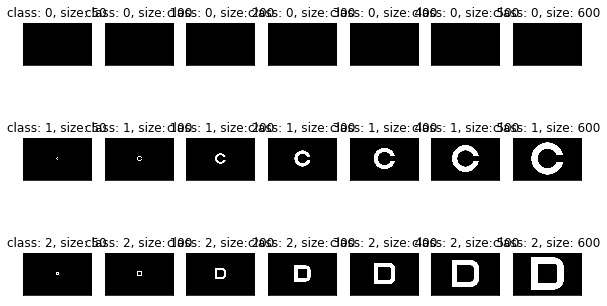

In [19]:
# visualize the size_letter_to_frame ndarray for first 3 classes

fig, axes = plt.subplots(3,n_sizes, figsize=(10,6))
for s, size in enumerate(sizes):
    for l, letter in enumerate(glia.letter_classes[:3]):
        ax = axes[l,s]
        ax.imshow(size_letter_to_frame[s,l])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"class: {l}, size: {size}")

## SVM classification

In [20]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split

In [21]:
# this may take a few minutes
training_100ms = glia.bin_100ms(np.expand_dims(data["training_data"],0))
validation_100ms = glia.bin_100ms(np.expand_dims(data["validation_data"],0))

## Pixel value inference

In [22]:
import torch, cv2
from torch import nn, optim, utils
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.nn import functional as F
import torchvision.utils
from dataclasses import dataclass

torch.manual_seed(20200525); # reproducible analysis
np.random.seed(seed=20200525)

### data munging

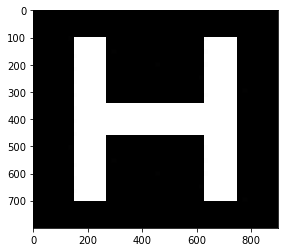

In [23]:
# choose crop parameters
biggest = max(sizes)
w1 = int((W - biggest*1.5) / 2)
w2 = W - w1
h1 = max(0, int((H - biggest*1.5) / 2))
h2 = H - h1
plt.imshow(size_letter_to_frame[-1,3,h1:h2,w1:w2])

In [24]:
(w1, w2), (h1, h2) 

((190, 1090), (0, 800))

In [47]:
all_data = np.concatenate([training_100ms, validation_100ms], axis=2)[0]
all_targets = np.concatenate([data["training_target"], data["validation_target"]], axis=1)

# reshape to remove size dimension
nskip = 3
n_examples = np.product([all_data.shape[0]-nskip, all_data.shape[1]])
X = np.zeros([n_examples, *all_data.shape[2:]])
# to avoid blowing up RAM, we store (size, letter)
# and will use dataloader to get the frame during training
Y = np.zeros([n_examples, 2], dtype=np.uint8)

print(f"warning: SKIPPING {nskip} SIZES")
for s,size in enumerate(sizes[nskip:], start=nskip):
    for n,(x,l) in enumerate(zip(all_data[s], all_targets[s])):
        i = n * (n_sizes-nskip) + s - nskip
        X[i] = x # time x H x W x C
        Y[i,0] = s # size index
        Y[i,1] = l # letter index
        
# del all_data, all_targets

# 90% train, 5% validation, 5% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=1)

# del X, Y

print("(N, T, H, W, C), (N, 2)")
print("train shapes: ", X_train.shape, Y_train.shape)
print("validation shapes: ", X_val.shape, Y_val.shape)
print("test shapes: ", X_test.shape, Y_test.shape)

(N, T, H, W, C), (N, 2)
train shapes:  (990, 2560) (990, 2)
validation shapes:  (55, 2560) (55, 2)
test shapes:  (55, 2560) (55, 2)


In [48]:
@dataclass
class LetterData(Dataset):
    X: np.ndarray
    Y: np.ndarray
    size_letter_to_frame: np.ndarray

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        size_idx = self.Y[i,0]
        letter_idx = self.Y[i,1]
        frame = self.size_letter_to_frame[size_idx, letter_idx]
        return self.X[i], frame
        
def resize_4d(images, fx, fy, interpolation=cv2.INTER_LINEAR, out="ndarray",
        is_tiff=False):
    im = cv2.resize((images[0,0]), None, fx=fx, fy=fy, interpolation=interpolation)
    if out=="ndarray":
        new = np.zeros([images.shape[0],images.shape[1], *im.shape],
            dtype = np.float32)
    elif out=="memmap":
        new = np.memmap("glia_temp_memmap.mmap", np.float32, "w+",
            (images.shape[0],images.shape[1], im.shape[0],im.shape[1]))
    for b, vol in enumerate(images):
        for z, img in enumerate(vol):
            new[b,z] = cv2.resize((img), None, fx=fx, fy=fy,
                interpolation=interpolation)
    return new

# downsample to 0.5x
small_size_letter_to_frame = resize_4d(size_letter_to_frame[:,:,h1:h2, w1:w2],1/16,1/16)[...,0]
# binarize
small_size_letter_to_frame = (small_size_letter_to_frame > 128).astype(np.float32)

train_data = LetterData(X_train, Y_train, small_size_letter_to_frame)
val_data = LetterData(X_val, Y_val, small_size_letter_to_frame)
test_data = LetterData(X_test, Y_test, small_size_letter_to_frame)
print(small_size_letter_to_frame.shape)

(7, 11, 50, 56)


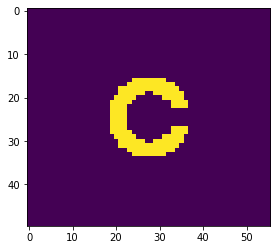

In [49]:
# look at smallest letter with downsampling 
# NOTE: WE SKIP THE SMALLEST
plt.imshow(small_size_letter_to_frame[nskip,1])
small_H, small_W = small_size_letter_to_frame[0,1].shape

###  variational autoencoder

In [50]:
# whether or not to use cuda
device = torch.device("cuda")

In [51]:
# Kingma & Welling (2014) style variational autoencoder

# subclass PyTorch Module for reverse-mode autodifferentiation 
# for easy backpropogation of loss gradient
class VAE(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_latent, n_hidden2, n_output,
                 nonlinearity=F.sigmoid):
        super(VAE, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_hidden = n_hidden
        self.nonlinearity = F.sigmoid
                
        # Encoder layers
        self.hidden_encoder = nn.Linear(n_input, n_hidden)
        # mean encoding layer 
        self.mean_encoder = nn.Linear(n_hidden, n_latent)
        # log variance encoding layer 
        self.logvar_encoder = nn.Linear(n_hidden, n_latent)
        
        # Decoder layers
        self.hidden_decoder = nn.Linear(n_latent, n_hidden2)
        self.reconstruction_decoder = nn.Linear(n_hidden2, n_output)

    def encode(self, x):
        h1 = self.nonlinearity(self.hidden_encoder(x))
        return self.mean_encoder(h1), self.logvar_encoder(h1)

    def reparameterize(self, mean, logvar):
        """Reparameterize out stochastic node so the gradient can propogate 
           deterministically."""

        if self.training:
            standard_deviation = torch.exp(0.5*logvar)
            # sample from unit gaussian with same shape as standard_deviation
            epsilon = torch.randn_like(standard_deviation)
            return epsilon * standard_deviation + mean
        else:
            return mean

    def decode(self, z):
        h3 = self.nonlinearity(self.hidden_decoder(z))
        # bound output to (0,1)
        return F.sigmoid(self.reconstruction_decoder(h3))

    
    def forward(self, x):
        "A special method in PyTorch modules that is called by __call__"
        mean, logvar = self.encode(x)
        # sample an embedding, z
        z = self.reparameterize(mean, logvar)
        # return the (sampled) reconstruction, mean, and log variance
        return self.decode(z), mean, logvar



def loss_function(recon_y, y, mu, logvar, beta=1):
    "Reconstruction + KL divergence losses summed over all elements and batch."
    BCE = F.binary_cross_entropy(recon_y, y, size_average=False)

    # we want KLD = - 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma is standard deviation and mu is mean
    # (see Appendix B of https://arxiv.org/abs/1312.6114)
    
    # see https://openreview.net/forum?id=Sy2fzU9gl for info on choosing Beta
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


    return BCE + beta * KLD

In [52]:
def train(epoch, model, optimizer, train_loader, beta=1., log_interval=10):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        bz = data[0].shape[0]
        # flatten batch x height x width x channel into batch x nFeatures
        X = data[0].reshape(bz, -1).to(device)
        Y = data[1].reshape(bz, -1).to(device) # flatten
        optimizer.zero_grad()
        Y_pred, mu, logvar = model(X)
        loss = loss_function(Y_pred, Y, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % log_interval == 0:
        print('Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))


def test(epoch, model, test_loader, H, W, beta=1., log_interval=10,
         save_image=True, folder="results", name="Test"):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            bz = data[0].shape[0]
            
            # flatten batch x height x width x channel into batch x nFeatures
            X = data[0].reshape(bz, -1).to(device)
            Y = data[1].reshape(bz, -1).to(device) # flatten

            Y_pred, mu, logvar = model(X)
            test_loss += loss_function(Y_pred, Y, mu, logvar).item()
            if (i == 0) and save_image:
                n = min(X.size(0), 15)
                comparison = torch.cat([Y[:n].view(-1,1,H,W),
                                   Y_pred[:n].view(-1, 1, H, W)])
                torchvision.utils.save_image(comparison.cpu(),
                         folder+f'/{name}_reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    if epoch % log_interval == 0:
        print(f'====> {name} ' + 'set loss: {:.4f}'.format(test_loss))



In [68]:
train_loader = DataLoader(LetterData(X_train.astype(np.float32),
        Y_train, small_size_letter_to_frame),
    batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(LetterData(X_val.astype(np.float32),
        Y_val, small_size_letter_to_frame),
    batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(LetterData(X_test.astype(np.float32),
        Y_test, small_size_letter_to_frame),
    batch_size=64, shuffle=True, pin_memory=True)

nfeatures = 28**2
# we use a latent space of dimension 2 as to get an easy-to-visualize manifold
# (see mnist/sample_*.png while running next cell)
n_input = np.prod(X_train.shape[1:])
n_hidden = 1000
n_latent = 2
n_hidden2 = 1000
beta = 10
lr = 3e-5
nonlinearity = F.celu
n_output = np.product(small_size_letter_to_frame.shape[2:])
est_params = n_input*n_hidden + n_hidden*n_latent + n_latent*n_hidden2 + n_hidden2*n_output
print(est_params)

model = VAE(n_input, n_hidden, n_latent, n_hidden2, n_output,
            nonlinearity=nonlinearity).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
!mkdir -p letters_viz && rm letters_viz/*

# this will take two minutes to run or so
# As it does, check out the letters_viz folder!
# each epoch, reconstruction examples are saved (original on top) 
# select files on right, then refresh, and double click image
# click bottom right corner of image to resize

nepochs = 100

# make grid of z1 x z2 where z1,z2 \elem (-3.5,-2.5, ..., 3.5)
nrow = 25
latents = torch.zeros(nrow,nrow,n_latent)
z1_tick = np.linspace(-3.5,3.5,nrow)
z2_tick = np.linspace(-3.5,3.5,nrow)
for i, z1 in enumerate(z1_tick):
    for j, z2 in enumerate(z2_tick):
        latents[i,j,[0,1]] = torch.tensor([z1,z2])
latents = latents.to(device)

for epoch in range(1, nepochs + 1):
    if epoch % 10 == 0:
        save_image = True
    else:
        save_image = False
    train(epoch, model, optimizer, train_loader, beta=beta)
    test(epoch, model, val_loader, small_H, small_W, beta=beta,
         save_image=save_image, folder='letters_viz', name="Validation")
    if save_image:
        with torch.no_grad():
            latent_space = model.decode(latents.view(-1,n_latent)).cpu()
            torchvision.utils.save_image(latent_space.view(-1, 1, small_H, small_W),
                       'letters_viz/sample_' + str(epoch) + '.png',nrow=nrow)

5364000
Epoch: 10 Average loss: 1007.3247
====> Validation set loss: 998.3933
Epoch: 20 Average loss: 876.1274
====> Validation set loss: 880.9705
Epoch: 30 Average loss: 810.4409
====> Validation set loss: 819.8396
Epoch: 40 Average loss: 709.4315
====> Validation set loss: 744.5324
Epoch: 50 Average loss: 646.7073
====> Validation set loss: 716.6578
Epoch: 60 Average loss: 607.9758
====> Validation set loss: 703.3165
Epoch: 70 Average loss: 577.7620
====> Validation set loss: 693.8460
Epoch: 80 Average loss: 554.1780
====> Validation set loss: 690.3384
Epoch: 90 Average loss: 535.2322
====> Validation set loss: 692.7732
Epoch: 100 Average loss: 519.7425
====> Validation set loss: 697.2898


In [69]:
test(epoch, model, test_loader, small_H, small_W, beta=beta,
         save_image=save_image, folder='letters_viz', name="Test")

====> Test set loss: 665.7424
